In [140]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas

import pandas_ta as ta
from fastai.tabular.all import add_datepart

import datetime
from dateutil.relativedelta import relativedelta

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.metrics import mean_absolute_error

import trade


## Initializations

In [141]:
ticker = 'NVDA'

outfile = ('./Resources/' + str(ticker) +'_out.csv') # output data for review

stock_data_period = '4y'
stock_data_interval = '1d'

share_size = 10
initial_capital = 5000

___
## Get live data

In [142]:
# Get live stock data
stock_df = pd.DataFrame()
stock_df = stock_df.ta.ticker(ticker, period = stock_data_period, interval = stock_data_interval)
stock_df.drop(columns=['Dividends', 'Stock Splits'],inplace=True,axis=1)
stock_df

,Open,High,Low,Close,Volume
Date,,,,,
2018-10-05,69.011344,69.633778,66.345521,66.920837,42663600
2018-10-08,66.087624,67.243228,64.495566,65.906593,40861200
2018-10-09,65.700749,66.648048,65.170061,65.849541,27350000
2018-10-10,64.788192,65.246956,60.904768,60.927086,68494000
2018-10-11,60.054187,61.390818,58.092636,58.308384,72543600
...,...,...,...,...,...
2022-09-28,124.099998,128.229996,123.540001,127.360001,54241400
2022-09-29,124.480003,125.000000,119.459999,122.199997,53276300
2022-09-30,120.870003,126.330002,120.750000,121.389999,56486900


<AxesSubplot:xlabel='Date'>

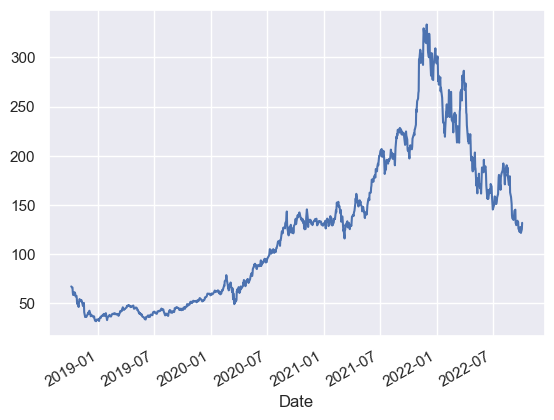

In [143]:
#Plot the True Adj Close Value
stock_df['Close'].plot()

In [144]:
df = stock_df.copy()     # reload copy of df here instead of downloading

---
## Machine Learning - XGBoost

#### Add features

In [145]:
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 4,50, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": sma_long},
        {"kind": "sma", "length": sma_short},
        {"kind": "bbands", "length": bbands_period},
        {"kind": "rsi"},
        {"kind": "macd", "fast": macd_fast, "slow": macd_slow},
        {"kind": "sma", "close": "volume", "length": sma_period, "prefix": "VOLUME"},
    ]
)
# Run "Custom Strategy" to add additional features/columns to dataframe.
df.ta.strategy(CustomStrategy)

In [146]:
df['Actual Returns'] = df['Close'].pct_change()
df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']]=df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']].shift(-1)
df.head()

,Open,High,Low,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20,Actual Returns
Date,,,,,,,,,,,,,,,,,,
2018-10-05,69.011344,69.633778,66.345521,65.906593,42663600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-08,66.087624,67.243228,64.495566,65.849541,40861200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015156
2018-10-09,65.700749,66.648048,65.170061,60.927086,27350000,NaN,64.901014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000866
2018-10-10,64.788192,65.246956,60.904768,58.308384,68494000,NaN,62.747901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.074753
2018-10-11,60.054187,61.390818,58.092636,61.137859,72543600,NaN,61.555717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042981


#### Generate Trading Signal

In [147]:
# Generate buy/sell signal
df['Signal'] = 0.0
# Generate signal to buy stock
df.loc[(df['Actual Returns'] >= 0), 'Signal'] = 1
# Generate signal to sell stock
df.loc[(df['Actual Returns'] < 0), 'Signal'] = 0

In [148]:
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20,Actual Returns,Signal
0,2018-10-05,69.011344,69.633778,66.345521,65.906593,42663600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2018-10-08,66.087624,67.243228,64.495566,65.849541,40861200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015156,0.0
2,2018-10-09,65.700749,66.648048,65.170061,60.927086,27350000,NaN,64.901014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000866,0.0
3,2018-10-10,64.788192,65.246956,60.904768,58.308384,68494000,NaN,62.747901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.074753,0.0
4,2018-10-11,60.054187,61.390818,58.092636,61.137859,72543600,NaN,61.555717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042981,0.0


## Add date related features/coumns to dataframe

In [149]:
add_datepart(df, 'Date', drop=False)

,Date,Open,High,Low,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2018-10-05,69.011344,69.633778,66.345521,65.906593,42663600,NaN,NaN,NaN,NaN,...,5,4,278,False,False,False,False,False,False,1.538698e+09
1,2018-10-08,66.087624,67.243228,64.495566,65.849541,40861200,NaN,NaN,NaN,NaN,...,8,0,281,False,False,False,False,False,False,1.538957e+09
2,2018-10-09,65.700749,66.648048,65.170061,60.927086,27350000,NaN,64.901014,NaN,NaN,...,9,1,282,False,False,False,False,False,False,1.539043e+09
3,2018-10-10,64.788192,65.246956,60.904768,58.308384,68494000,NaN,62.747901,NaN,NaN,...,10,2,283,False,False,False,False,False,False,1.539130e+09
4,2018-10-11,60.054187,61.390818,58.092636,61.137859,72543600,NaN,61.555717,NaN,NaN,...,11,3,284,False,False,False,False,False,False,1.539216e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2022-09-28,124.099998,128.229996,123.540001,122.199997,54241400,159.149789,123.992498,119.198003,132.255902,...,28,2,271,False,False,False,False,False,False,1.664323e+09
1002,2022-09-29,124.480003,125.000000,119.459999,121.389999,53276300,157.968661,123.769999,117.909075,131.358972,...,29,3,272,False,False,False,False,False,False,1.664410e+09
1003,2022-09-30,120.870003,126.330002,120.750000,125.120003,56486900,157.008290,124.017500,117.292992,130.793499,...,30,4,273,True,False,True,False,False,False,1.664496e+09
1004,2022-10-03,123.470001,126.779999,121.050003,131.669998,54747800,156.237901,125.094999,117.251808,130.646499,...,3,0,276,False,False,False,False,False,False,1.664755e+09


In [150]:
# Drop irrelevant columns
df.drop(columns=['Open', 'High', 'Low', 'Year'],inplace=True,axis=1)

In [151]:
df=df.iloc[51:]
df=df.iloc[:-1]
df.head()

,Date,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
51,2018-12-19,33.536098,74536400,46.257034,35.008735,33.385233,37.458953,41.532673,21.750314,0.018517,...,19,2,353,False,False,False,False,False,False,1.545178e+09
52,2018-12-20,32.163383,74958800,45.681760,34.139303,32.628462,37.272837,41.917212,24.920965,-0.050069,...,20,3,354,False,False,False,False,False,False,1.545264e+09
53,2018-12-21,31.545280,86374000,45.146498,32.906833,31.799549,37.052220,42.304891,28.352801,-0.024204,...,21,4,355,False,False,False,False,False,False,1.545350e+09
54,2018-12-24,33.039631,46384000,44.584534,32.571098,31.292287,36.806507,42.320728,29.963291,0.158440,...,24,0,358,False,False,False,False,False,False,1.545610e+09
55,2018-12-26,32.560543,69510000,44.068337,32.327209,30.752897,36.528409,42.303921,31.622031,0.156492,...,26,2,360,False,False,False,False,False,False,1.545782e+09


In [152]:
df=df.set_index(['Date'])

In [153]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
df['Entry/Exit'] = df['Signal'].diff()
df = df.dropna()

df.head()

,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-20,32.163383,74958800,45.681760,34.139303,32.628462,37.272837,41.917212,24.920965,-0.050069,28.970597,...,3,354,False,False,False,False,False,False,1.545264e+09,0.0
2018-12-21,31.545280,86374000,45.146498,32.906833,31.799549,37.052220,42.304891,28.352801,-0.024204,27.979334,...,4,355,False,False,False,False,False,False,1.545350e+09,0.0
2018-12-24,33.039631,46384000,44.584534,32.571098,31.292287,36.806507,42.320728,29.963291,0.158440,33.870525,...,0,358,False,False,False,False,False,False,1.545610e+09,0.0
2018-12-26,32.560543,69510000,44.068337,32.327209,30.752897,36.528409,42.303921,31.622031,0.156492,32.940231,...,2,360,False,False,False,False,False,False,1.545782e+09,1.0
2018-12-27,33.176159,63704400,43.512624,32.580403,30.442791,36.202481,41.962170,31.819309,0.237284,35.395724,...,3,361,False,False,False,False,False,False,1.545869e+09,-1.0


In [154]:
df['Entry/Exit'].value_counts()

 0.0    458
 1.0    248
-1.0    247
Name: Entry/Exit, dtype: int64

In [155]:
# Visualize entry position relative to close price
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': Entry and Exit Points')
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

___
## Backtest trading strategy without Machine Learning

#### Execute trades (buy, hold, sell) and calculate P&L

In [156]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
pl_df = df[['Close', 'Signal', 'Entry/Exit']].copy()

# Execute trades to calculate gain loss
pl_df, accumulated_shares = trade.gain_loss(pl_df, share_size)

In [157]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = pl_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $16,393.10
The trading algorithm resulted in a return on investment of 327.86%


#### Calculate and plot porfolio value

In [158]:
pl_df = trade.calc_portfolio_value(pl_df, share_size, initial_capital)
pl_df.head()

,Close,Signal,Entry/Exit,trade_type,cost/proceeds,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2018-12-20,32.163383,0.0,0.0,hold,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-21,31.545280,0.0,0.0,hold,NaN,0.0,0.0,0.000000,5000.000000,5000.000000,NaN,NaN
2018-12-24,33.039631,0.0,0.0,hold,NaN,0.0,0.0,0.000000,5000.000000,5000.000000,0.000000,0.000000
2018-12-26,32.560543,1.0,1.0,buy,-3256.054306,10.0,10.0,325.605431,4674.394569,5000.000000,0.000000,0.000000
2018-12-27,33.176159,0.0,-1.0,sell,3317.615891,0.0,-10.0,0.000000,5006.156158,5006.156158,0.001231,0.001231


In [159]:
# Visualize exit positions relative to total portfolio value
entry = pl_df[pl_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize entry positions relative to total portfolio value
exit = pl_df[pl_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the total portoflio value for the investment
total_portfolio_value = pl_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title=(ticker + ' - Total Portfolio Value'),
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

#### Show the portfolio evaluation metrics

In [160]:
pl_df.head()

,Close,Signal,Entry/Exit,trade_type,cost/proceeds,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2018-12-20,32.163383,0.0,0.0,hold,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-21,31.545280,0.0,0.0,hold,NaN,0.0,0.0,0.000000,5000.000000,5000.000000,NaN,NaN
2018-12-24,33.039631,0.0,0.0,hold,NaN,0.0,0.0,0.000000,5000.000000,5000.000000,0.000000,0.000000
2018-12-26,32.560543,1.0,1.0,buy,-3256.054306,10.0,10.0,325.605431,4674.394569,5000.000000,0.000000,0.000000
2018-12-27,33.176159,0.0,-1.0,sell,3317.615891,0.0,-10.0,0.000000,5006.156158,5006.156158,0.001231,0.001231


In [161]:
# # Review the portfolio evaluation DataFrame
# portfolio_metrics = trade.portfolio_metrics(pl_df)
# print(f"The Annualized Return is {portfolio_metrics['Backtest'][0]*100:,.2f}%")
# print(f"The Cummulative Return is {portfolio_metrics['Backtest'][1]*100:,.2f}%")
# print(f"The Annual Volatility is {portfolio_metrics['Backtest'][2]:,.2f}")
# print(f"The Sharpe Ratio is {portfolio_metrics['Backtest'][3]:,.2f}")
# print(f"The Sortino Ratio is {portfolio_metrics['Backtest'][4]:,.2f}")

---
## Machine Learning

#### Extract features and target

In [162]:
# Extract features 
X = df.drop(columns=['Actual Returns', 'Signal'])
X.head()

,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-20,32.163383,74958800,45.681760,34.139303,32.628462,37.272837,41.917212,24.920965,-0.050069,28.970597,...,3,354,False,False,False,False,False,False,1.545264e+09,0.0
2018-12-21,31.545280,86374000,45.146498,32.906833,31.799549,37.052220,42.304891,28.352801,-0.024204,27.979334,...,4,355,False,False,False,False,False,False,1.545350e+09,0.0
2018-12-24,33.039631,46384000,44.584534,32.571098,31.292287,36.806507,42.320728,29.963291,0.158440,33.870525,...,0,358,False,False,False,False,False,False,1.545610e+09,0.0
2018-12-26,32.560543,69510000,44.068337,32.327209,30.752897,36.528409,42.303921,31.622031,0.156492,32.940231,...,2,360,False,False,False,False,False,False,1.545782e+09,1.0
2018-12-27,33.176159,63704400,43.512624,32.580403,30.442791,36.202481,41.962170,31.819309,0.237284,35.395724,...,3,361,False,False,False,False,False,False,1.545869e+09,-1.0


In [163]:
# Extract target
y = df['Signal']

y.value_counts()

1.0    516
0.0    437
Name: Signal, dtype: int64

#### Split train - test data

In [164]:
training_begin = X.index.min() + DateOffset(months=14)
training_end = X.index.max() - DateOffset(months=5)
print(training_begin)
print(training_end) 

2020-02-20 00:00:00
2022-05-03 00:00:00


In [165]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [166]:
# Scale the features data

scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(556, 27) (556,)
(106, 27) (106,)


In [167]:
# Use RandomOverSampler to resample the dataset using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
print(len(X_resampled))
print(len(y_resampled))

602
602


#### Train machine learning model using XGBoost

In [168]:
# Instantiate model using XGBClassifier
model = xgb.XGBClassifier()

# Fit/train the model
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict trading signals
training_signal_predictions = model.predict(X_resampled)

In [169]:
# Print classification report on training dataset
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       301
         1.0       1.00      1.00      1.00       301

    accuracy                           1.00       602
   macro avg       1.00      1.00      1.00       602
weighted avg       1.00      1.00      1.00       602



In [170]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
testing_report = classification_report(y_test, testing_signal_predictions)

print(testing_report)


              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86        54
         1.0       0.86      0.85      0.85        52

    accuracy                           0.86       106
   macro avg       0.86      0.86      0.86       106
weighted avg       0.86      0.86      0.86       106



In [171]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['Predicted Signal'] = testing_signal_predictions

# Add in actual returns and calculate trading returns
predictions_df['Actual Returns'] = df['Actual Returns']
predictions_df['ML Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted Signal']
predictions_df.tail(20)


,Predicted Signal,Actual Returns,ML Returns
Date,,,
2022-09-06,0,-0.013336,-0.000000
2022-09-07,1,0.018795,0.018795
2022-09-08,0,0.020125,0.000000
2022-09-09,0,0.028377,0.000000
2022-09-12,0,0.008202,0.000000
2022-09-13,0,-0.094726,-0.000000
2022-09-14,0,-0.000228,-0.000000
2022-09-15,0,-0.015158,-0.000000
2022-09-16,1,0.020806,0.020806


<AxesSubplot:xlabel='Date'>

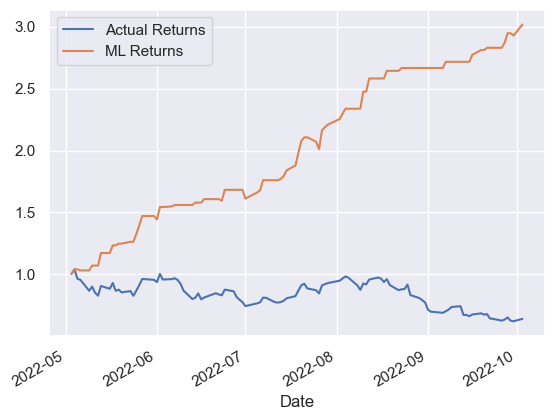

In [172]:
# Calculate and plot the cumulative returns for the `Actual Returns` and the `Algo Returns`
(1 + predictions_df[['Actual Returns', 'ML Returns']]).cumprod().plot()

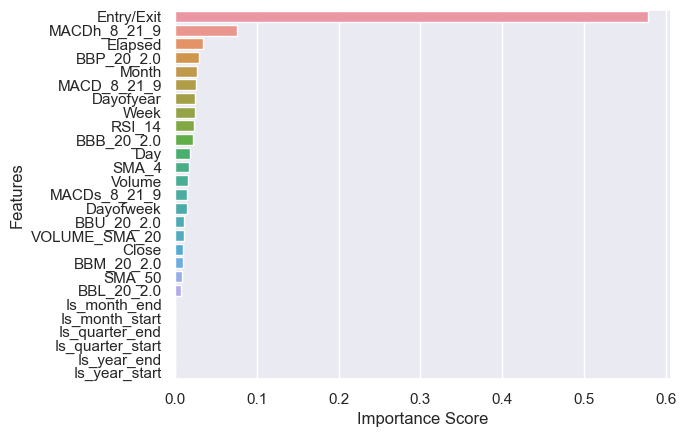

In [173]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

___
## Calculate P&L and ROI based on ML predicted trading signal

In [174]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
predictions_df['Close'] = df['Close']
predictions_df


,Predicted Signal,Actual Returns,ML Returns,Close
Date,,,,
2022-05-03,1,0.003533,0.003533,203.236618
2022-05-04,1,0.037343,0.037343,188.344208
2022-05-05,0,-0.073276,-0.000000,186.655060
2022-05-06,1,-0.008968,-0.008968,169.413834
2022-05-09,0,-0.092369,-0.000000,175.860550
...,...,...,...,...
2022-09-27,1,0.015129,0.015129,127.360001
2022-09-28,1,0.026021,0.026021,122.199997
2022-09-29,0,-0.040515,-0.000000,121.389999


In [175]:
pl_df = predictions_df[['Close', 'Predicted Signal']].copy()
pl_df['Entry/Exit'] = pl_df['Predicted Signal'].diff()
pl_df.head()

,Close,Predicted Signal,Entry/Exit
Date,,,
2022-05-03,203.236618,1,NaN
2022-05-04,188.344208,1,0.0
2022-05-05,186.655060,0,-1.0
2022-05-06,169.413834,1,1.0
2022-05-09,175.860550,0,-1.0


In [176]:
pl_df['Entry/Exit'].value_counts()

 0.0    57
-1.0    24
 1.0    24
Name: Entry/Exit, dtype: int64

In [177]:
# Call function to calculate P&L
pl_df, accumulated_shares = trade.gain_loss(pl_df, share_size)

# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = pl_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $2,704.87
The trading algorithm resulted in a return on investment of 54.10%
